In [1]:
from time import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import os
import json
import networkx as nx
from tqdm import tqdm

In [2]:
with open('Data/ozon_train.txt') as f:
    df_train = pd.DataFrame(json.loads(line) for line in f)

In [3]:
with open('Data/catalog_path') as f:
    df_ctl_path = pd.DataFrame(json.loads(line) for line in f)

In [4]:
with open('Data/catalogs') as f:
    df_ctl = pd.DataFrame(json.loads(line) for line in f)

In [5]:
max_len = 0
path_len = []
for row in range(len(df_ctl_path)):
    if len(df_ctl_path.iloc[row]['catalogpath']) > max_len:
        max_len = len(df_ctl_path.iloc[row]['catalogpath'])
    path_len.append(len(df_ctl_path.iloc[row]['catalogpath']))
print max_len

10


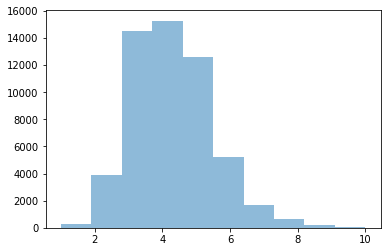

In [6]:
plt.hist(path_len, bins=10, alpha=0.5)
plt.show()

In [7]:
ctl_pairs = []
ctl_dict ={}
for row in tqdm(range(len(df_ctl_path))):
    for link in range(len(df_ctl_path.iloc[row]['catalogpath'])):
        if not df_ctl_path.iloc[row]['catalogpath'][link].keys()[0] in ctl_dict.keys():
            ctl_dict.update(df_ctl_path.iloc[row]['catalogpath'][link])
        ctl_pairs.append([str(df_ctl_path.iloc[row]['catalogid']),\
                          df_ctl_path.iloc[row]['catalogpath'][link].keys()[0]])

100%|██████████| 54504/54504 [16:45<00:00, 54.23it/s] 


In [8]:
for key in ctl_dict.keys():
    ctl_dict[key] =ctl_dict.get(key).strip()

In [9]:
G=nx.Graph()
for row in tqdm(range(len(df_ctl_path))):
    G.add_node(str(df_ctl_path.iloc[row]['catalogid']))

100%|██████████| 54504/54504 [00:06<00:00, 7887.96it/s]


In [10]:
for pair in ctl_pairs:
    G.add_edge(pair[0],pair[1])

In [11]:
df_train_ctl = df_train.merge(df_ctl,left_on='item', right_on='itemid')
del df_train_ctl['itemid']
df_train_ctl.head(10)

,item,true_recoms,catalogid
0,31471303,"{u'31471373': 1, u'31471307': 3, u'31471342': 1}",1146150
1,31489016,"{u'31760003': 1, u'31418187': 1, u'31418153': ...",1134295
2,5629613,"{u'19063915': 6, u'5821229': 1, u'19063895': 5...",1146151
3,24829740,"{u'32610140': 1, u'24829738': 1, u'24702299': 1}",1177309
4,29185962,"{u'1493930': 1, u'3711112': 1, u'33395696': 1}",1141544
5,20063162,"{u'4877941': 1, u'5705796': 2, u'6043090': 11,...",1139400
6,20063162,"{u'4877941': 1, u'5705796': 2, u'6043090': 11,...",1139414
7,30232057,"{u'30232028': 1, u'30232031': 1, u'30232026': ...",1179519
8,30232057,"{u'30232028': 1, u'30232031': 1, u'30232026': ...",1159236
9,32966349,"{u'32429470': 2, u'32865418': 2, u'26221282': 1}",1146140


Степень узла для каждой категории товара

In [12]:
df_train_ctl['degree_ctl'] = df_train_ctl['catalogid'].apply(lambda x: nx.degree(G,x))   

Среднее степень узлов плижайшего окружения

In [13]:
avg_nei_degree_dict = nx.average_neighbor_degree(G)
df_train_ctl['avg_nei_degree'] = df_train_ctl['catalogid'].apply(lambda x: avg_nei_degree_dict[x])

Число усзлов в локальной компоненте связанности

In [ ]:
tqdm.pandas()
df_train_ctl['num_nodes_comp'] = df_train_ctl['catalogid'].progress_apply(lambda x: nx.node_connected_component(G, x))

 23%|██▎       | 42551/188048 [19:00<106:15:23,  2.63s/it]

Функция для поиска общих категорий

In [22]:
list(nx.common_neighbors(G, '1146150', '1177309'))

[u'1132524', u'1145470']

In [12]:
import os
import sys

os.environ["PYSPARK_SUBMIT_ARGS"]='--packages com.databricks:spark-csv_2.10:1.2.0 pyspark-shell'
spark_home = os.environ.get('SPARK_HOME', None)
sys.path.insert(0, spark_home + "/python")

execfile(os.path.join(spark_home, 'python/pyspark/shell.py'))

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 2.1.1
      /_/

Using Python version 2.7.6 (default, Oct 26 2016 20:30:19)
SparkSession available as 'spark'.


In [40]:
df = spark.createDataFrame(df_train_ctl)

In [50]:
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import udf

num_node_comp = udf(lambda x: len(nx.node_connected_component(G, x)), IntegerType())
num_node_comp = df.withColumn('num_node_comp', num_node_comp(df['catalogid']))